In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as animation
import diffrax as dfx
import diffrax as diffrax
from PIL import Image
import numpy as np

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.shapes import Shape
from pde_opt.numerics.equations.allen_cahn import AllenCahn2DSmoothedBoundaryButlerVolmerConstantCurrent
from pde_opt.pde_model import PDEModel

In [2]:
jax.config.update('jax_enable_x64', True)

In [3]:
binary_mask = np.zeros((100, 100))
center = (50, 50)
radius = 30
y, x = np.ogrid[:100, :100]
dist_from_center = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
binary_mask[dist_from_center <= radius] = 1

shape = Shape(
    binary=jnp.array(binary_mask),
    dx=(1.0, 1.0),
    smooth_epsilon=3.0,
    smooth_curvature=0.008,
    smooth_dt=0.01,
    smooth_tf=100.0,
)

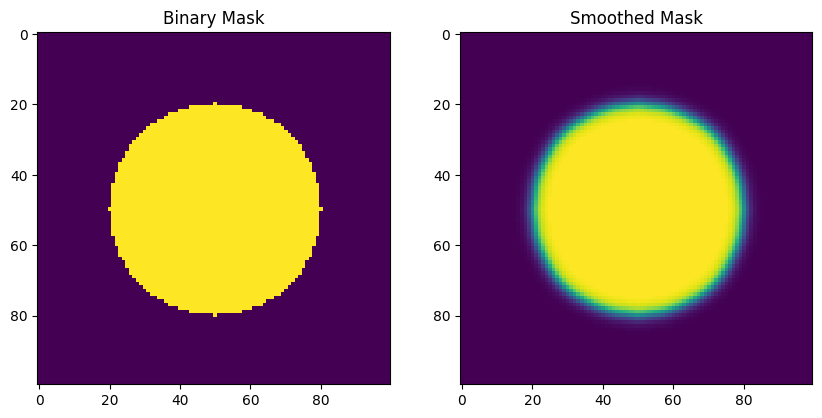

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(shape.binary)
axs[0].set_title("Binary Mask")
axs[1].imshow(shape.smooth)
axs[1].set_title("Smoothed Mask")
plt.show()

In [5]:
Nx, Ny = binary_mask.shape
Lx = 0.01 * Nx
Ly = 0.01 * Ny

domain = Domain(
    (Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless", shape
)

In [6]:
t_start = 0.0
t_final = 10.0
dt = 0.000001

ts_save = jnp.linspace(t_start, t_final, 200)

kappa = 0.002

In [22]:
eq = AllenCahn2DSmoothedBoundaryButlerVolmerConstantCurrent(
    domain,
    kappa,
    lambda c: c * jnp.log(c) + (1.0 - c) * jnp.log(1.0 - c) + 3.0 * c * (1.0 - c) + 0.059,
    lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
    lambda c: jnp.sqrt((1.0 - c) * c),
    0.5,
    0.02,
    derivs="fd"
)

solver = dfx.Tsit5()

In [23]:
key = random.PRNGKey(0)
u0 = jnp.clip(0.1 * jnp.ones((Nx, Ny)) + 0.1 * random.normal(key, (Nx, Ny)), 0.05, 1.0)
print(jnp.max(u0))
print(jnp.min(u0))

0.49981978034999486
0.05


In [24]:
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    solver,
    t0=t_start,
    t1=t_final,
    dt0=dt,
    y0=u0,
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
    saveat=diffrax.SaveAt(ts=ts_save),
    max_steps=1000000,
)

In [25]:
fig, ax = plt.subplots(figsize=(4,4))

ims = []
for i in range(0, len(solution.ys), 10):
    im = ax.imshow(solution.ys[i] * domain.geometry.binary, animated=True, 
                   vmin=0.0, vmax=1.0,
                   extent=[domain.box[0][0], domain.box[0][1], 
                          domain.box[1][0], domain.box[1][1]])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True)

plt.title('Allen-Cahn Evolution with Smoothed Boundary')
plt.xlabel('x')
plt.ylabel('y')

plt.close()

HTML(ani.to_jshtml())

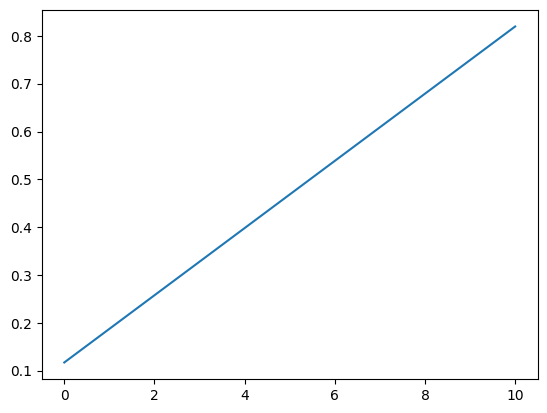

In [29]:
plt.plot(solution.ts, jnp.sum(solution.ys * domain.geometry.binary[None], axis=(1,2)) / jnp.sum(domain.geometry.binary[None]))

In [27]:
voltages = jax.vmap(eq.get_voltage)(solution.ys)

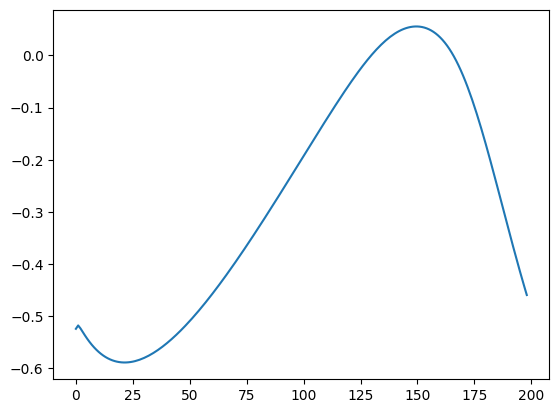

In [28]:
plt.plot(voltages[1:])